# Oprava projektu po odovzdaní
## Pripomienky

<ol>
  <li><strike>Bylo by lepší přidat nějaké popisky u toho featurePlot, např. pomocí parametrů main = "main", labels = c("xlab", "ylab").</strike></li>
  <li><strike><strong>Texty s kódy by bylo možné lépe "učesat"</strong></strike></li>
  <li><strike>Bylo by vhodné dopsat, co nám ukazují ty kódy quantile(train_processed\$shares) a quantile(test_processed\$shares) v Part 2: Pre-processing (Centering and scaling) </strike></li>
  <li><strike>Ty nadpisy by měly být udělány pořádně - I to rozdělení kapitol. Introduction máte jako header úrovně 1, pak Preprocessing phases úrovně 2 a další nadpisy jsou jen v kódu a nejsou ty vysázeny jako markdown.</strike></li>
  <li><strike>Chybí tam textový popis těch metod předzpracování</strike></li>
  <li><strike>Popisovat Cross Validation nebylo potřeba, ale už to tam nechte. A ten nadpis Description of cross-validation bych spíš přepsal na něco jako Training by cross-validation.</strike></li>
  <li><strike>PCR není přímo PCA. Je to metoda založená na PCA a bylo by lepší popsat, jak je v tom PCA použito. Vy jste popsal čistě PCA.</strike></li>
  <li>
   <strike>V tom závěru máte chybu. Ono to není lepší na testovacích datech. RMSE je chyba, takže menší je lepší - no a menší je na trénovací množině.</strike>
    <div>Ako som písal v Conclusion, "this is subject to change if different random seed is used". Po zmene random seed z "321" na "123" už RMSE vychádza menšie ("lepšie") pre testovacie dáta, než pre trénovacie. Z <a href="https://stats.stackexchange.com/q/105737">literatúry</a> som nakoniec usúdil, že RMSE buď nie je vhodná testovacia metrika, alebo platí čo som napísal v tom závere.</div>

  </li>
  <li><strike>Conclusion: "overfitting is defined as an existance of hypothesis performing better on test data and worse on train data." - toto není pravda</strike></li>
</ol>

# 1. Introduction
## problem statement
I am going to use three **Linear Regression** models to investigate the **Online News Popularity Data Set**. The datased contains 61 attributes (a.k.a. variables, or factors), out of which 2 are non-predictive, another 2 will be proven unusable and 1 is the target (a.k.a. goal) variable. The target variable is called "shares" and represents "the number of shares in social networks (popularity)". Only 6 variables are in fact relevant (important) for predictions in most models, however, all variables will be used.

In [1]:
library(caret)
news <- read.csv("news.csv", stringsAsFactors = T)
set.seed(123) # Setting the seed to make the split reproductible.

Loading required package: lattice
Loading required package: ggplot2


# 2. Exploratory Analysis
## data description and visualizations

I am visualizing a subset called "predictors" of features to be used for linear regression. The subset choice has been based on the used models.

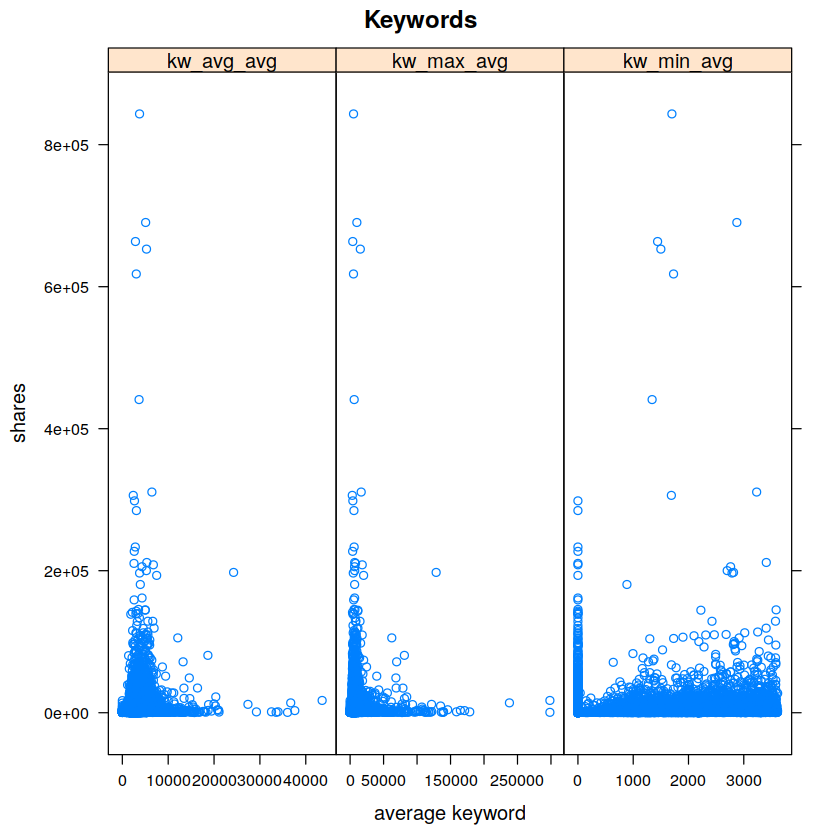

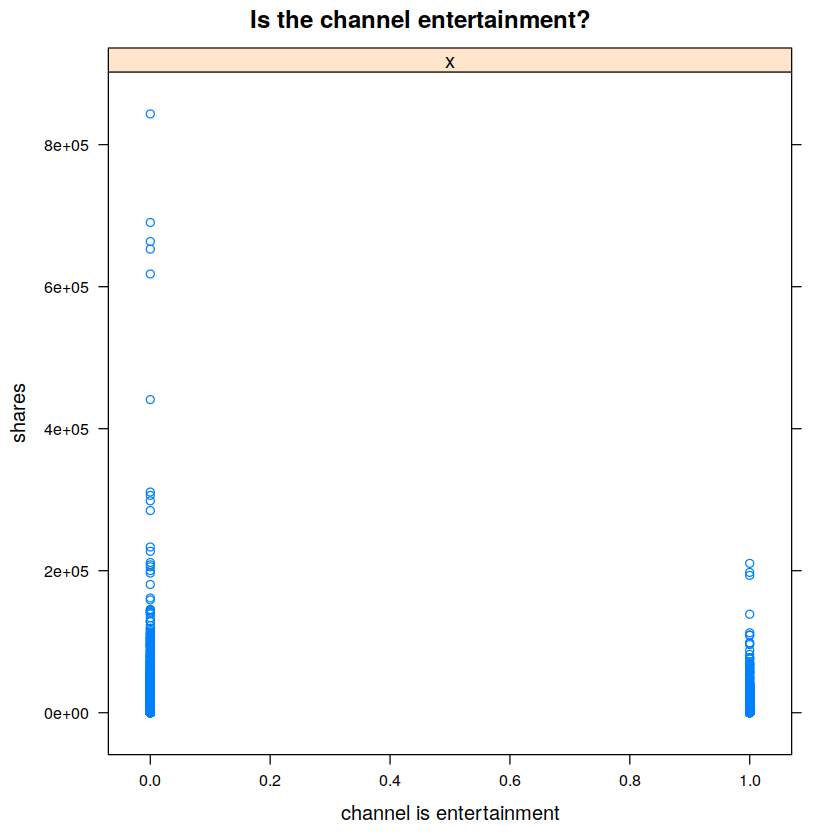

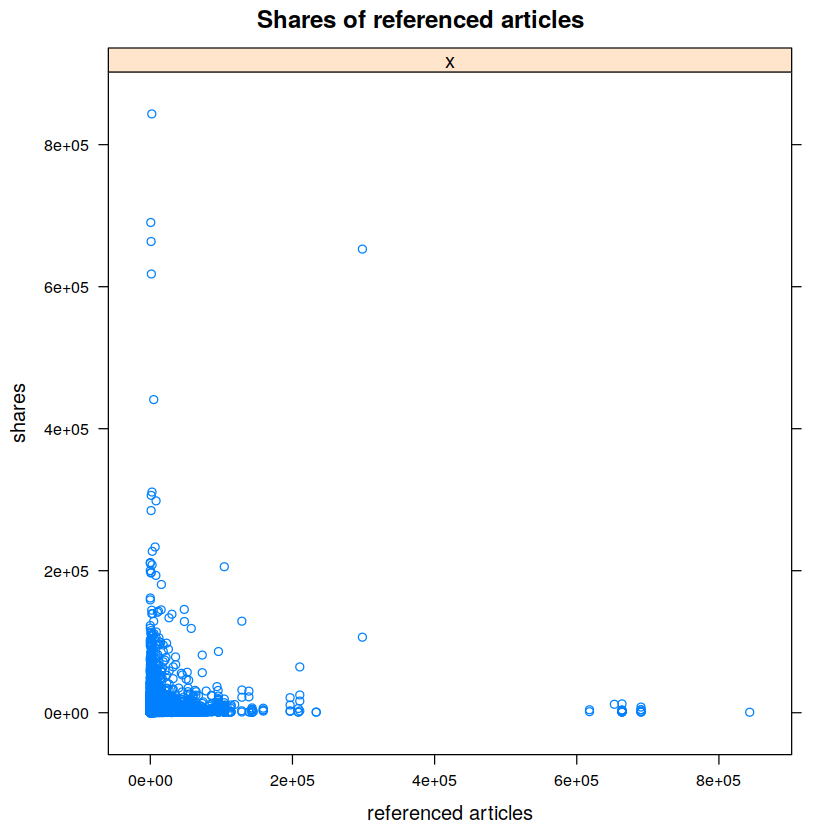

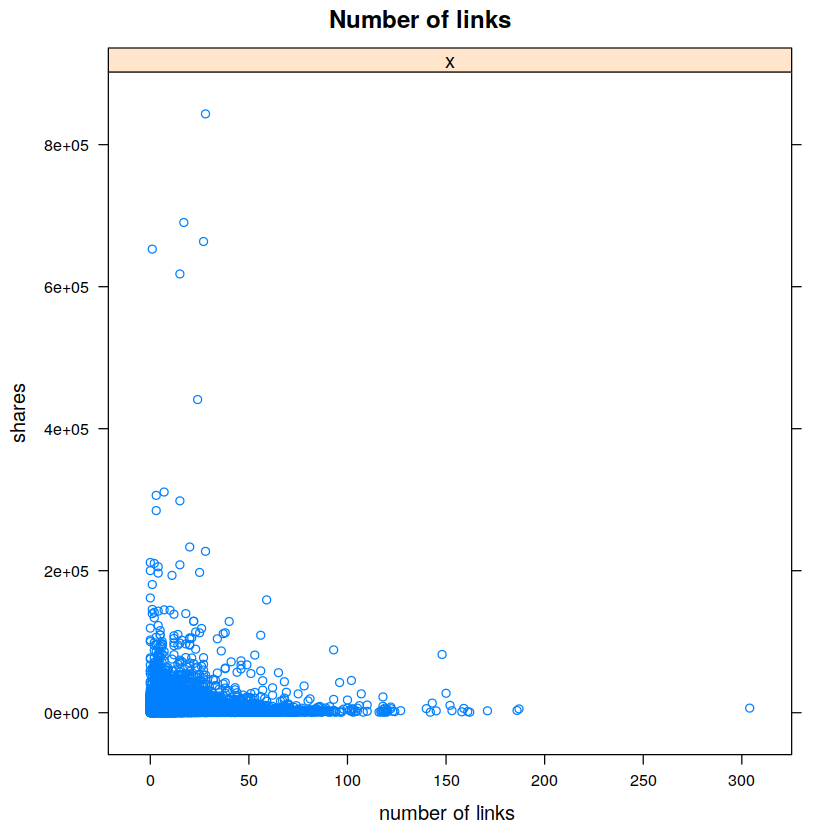

In [2]:
predictors <- c("kw_min_avg", 
              "kw_avg_avg",
              "kw_max_avg",
              "data_channel_is_entertainment",
              "self_reference_min_shares",
              "num_hrefs" 
              )
    
keywords <- c("kw_min_avg", 
              "kw_avg_avg",
              "kw_max_avg"
              )

featurePlot(x = news[, keywords], 
            y = news$shares, 
            plot = "scatter",
            labels = c("average keyword", "shares"),
            main = "Keywords",
            layout = c(3, 1)
            )
  
featurePlot(x = news[, "data_channel_is_entertainment"], 
            y = news$shares, 
            plot = "scatter",
            labels = c("channel is entertainment", "shares"),
            main = "Is the channel entertainment?"
            )

featurePlot(x = news[, "self_reference_min_shares"], 
            y = news$shares, 
            plot = "scatter",
            labels = c("referenced articles", "shares"),
            main = "Shares of referenced articles"
            )

featurePlot(x = news[, "num_hrefs"], 
            y = news$shares, 
            plot = "scatter",
            labels = c("number of links ", "shares"),
            main = "Number of links"
            )

# 3. Preprocessing

## Preprocessing phases

1. data splitting
2. preProcess on train set -> result is a model
3. apply model from 2. on train set using function predict
4. apply model from 2. on test set using function predict

## 3.1 Data splitting

Spliting training set into two parts based on outcome: 80% and 20% with the aim to avoid overfitting. The model is going to be trained on the (larger) training set and tested on the test set.

In [3]:
news_size <- nrow(news)
smp_size <- floor(0.8 * news_size)
chosen_ind <- sample(seq_len(nrow(news)), size = smp_size)

train <- news[chosen_ind,]
test <- news[-chosen_ind,]

## 3.2 Centering and scaling

In [4]:
sum(is.na(news))

[1] 0

There are no missing values. Therefore, no imputing (KNN) is required.

In [5]:
preProcValues <- preProcess(train, method = c("center","scale"))

Citing the documentation,

method = "**center**" subtracts the mean of the predictor's data (again from the data in x) from the predictor values

while

method = "**scale**" divides by the standard deviation.

The "range" transformation scales the data to be within [0, 1]. If new samples have values larger or smaller than those in the training set, values will be outside of this range.
Predictors that are not numeric are ignored in the calculations.

source: R Documentation for CARET

In [6]:
train_processed <- predict(preProcValues, train)
quantile(train_processed$shares)  

test_processed <- predict(preProcValues, test)
quantile(test_processed$shares)  

0%         25%         50%         75%        100% 
-0.28759049 -0.20717438 -0.16866645 -0.04965741 71.39827018

0%         25%         50%         75%        100% 
-0.28733547 -0.20759941 -0.16016581 -0.04965741 55.21304066

I have chosen quantiles (instead of the arithmetic or geometric mean) to better depict the distribution of the centered and scaled values, that have been obtained during the pre-processing phase.

## 3.3 Removing inadmissible variables from test set

Taking care of the non-predictive attributes "url" and "timedelta".

In [7]:
nonpredictive <- c("url", "timedelta")

# removing redundant variables to (parially) limit the warning
# "prediction from a rank-deficient fit may be misleading"
# source: http://rickchungtw-blog.logdown.com/posts/957748-r-language-glm-warning-prediction-from-a-rank-deficient-fit-may-be-misleading
redundant <- c("weekday_is_sunday", "is_weekend")

# no dummyVars() is needed now, since all types are numerical (ordinal)

admissible <- names(train_processed)[!names(train_processed) %in% union(redundant,nonpredictive)]
train_processed <- train_processed[, admissible]

# 4. Learning Algorithms
## description of the algorithms

### Training by cross-validation

"Cross-validation, sometimes called rotation estimation, is a model validation technique for assessing how the results of a statistical analysis will **generalize to an independent data set**. It is mainly used in settings where the goal is prediction, and one wants to estimate how accurately a predictive model will perform in practice. 

In a prediction problem, a model is usually given a dataset of known data on which training is run (**training** dataset), and a dataset of unknown data (or first seen data) against which the model is tested (**testing** dataset). The goal of cross validation is to define a dataset to **"test" the model in the training phase** (i.e., the validation dataset), in order to limit problems like **overfitting**, give an insight on how the model will generalize to an independent dataset (i.e., an unknown dataset, for instance from a real problem), etc."

source: https://en.wikipedia.org/wiki/Cross-validation_(statistics)

In [8]:
fitControl <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 10,
                           ## repeated ten times
                           repeats = 10)

In [9]:
library(pls, warn.conflicts = FALSE)

## Linear Regression with selected features


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
   Min     1Q Median     3Q    Max 
-3.230 -0.186 -0.116 -0.024 71.262 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    2.970e-17  5.567e-03   0.000 1.000000    
kw_min_avg                    -4.485e-02  7.321e-03  -6.127 9.05e-10 ***
kw_avg_avg                     2.122e-01  1.254e-02  16.927  < 2e-16 ***
kw_max_avg                    -1.071e-01  1.118e-02  -9.579  < 2e-16 ***
data_channel_is_entertainment -1.842e-02  5.571e-03  -3.307 0.000945 ***
self_reference_min_shares      2.366e-02  5.600e-03   4.224 2.40e-05 ***
num_hrefs                      3.034e-02  5.616e-03   5.403 6.59e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9914 on 31708 degrees of freedom
Multiple R-squared:  0.01727,	Adjusted R-squared:  0.01708 
F-statistic: 92.87 on 6 and 31708 DF,  p-value: < 2.2e-16


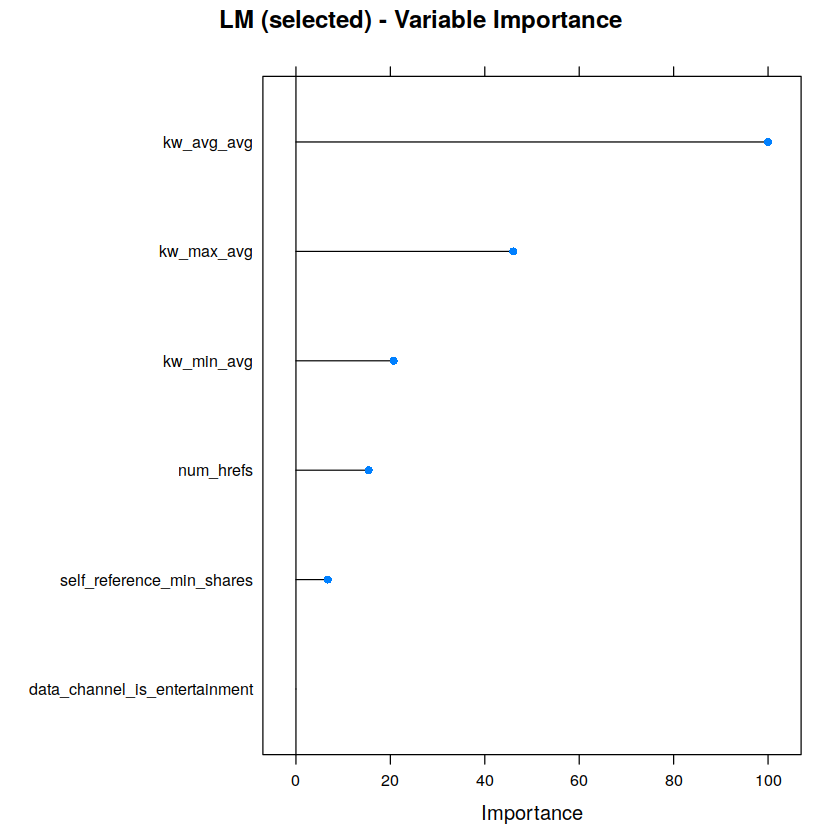

In [10]:
model_lm_sel<-train(train_processed[,predictors],train_processed[,"shares"],method='lm', trControl = fitControl)
plot(varImp(object=model_lm_sel),main="LM (selected) - Variable Importance")
summary(model_lm_sel)

## Linear Regression

Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(modelFit, newdat


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
   Min     1Q Median     3Q    Max 
-3.047 -0.190 -0.103 -0.010 71.182 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   -1.641e-15  5.559e-03   0.000 1.000000    
n_tokens_title                 1.709e-02  5.833e-03   2.931 0.003385 ** 
n_tokens_content               2.633e-02  1.012e-02   2.603 0.009243 ** 
n_unique_tokens                1.139e+00  7.284e-01   1.564 0.117791    
n_non_stop_words              -1.145e+00  2.996e+00  -0.382 0.702413    
n_non_stop_unique_tokens      -3.849e-01  5.733e-01  -0.671 0.501983    
num_hrefs                      2.384e-02  7.263e-03   3.282 0.001031 ** 
num_self_hrefs                -2.046e-02  6.575e-03  -3.112 0.001859 ** 
num_imgs                       7.879e-03  7.117e-03   1.107 0.268286    
num_videos                     4.873e-03  6.203e-03   0.785 0.432186    
average_token_length          -2.746e-02  1.968e-02 

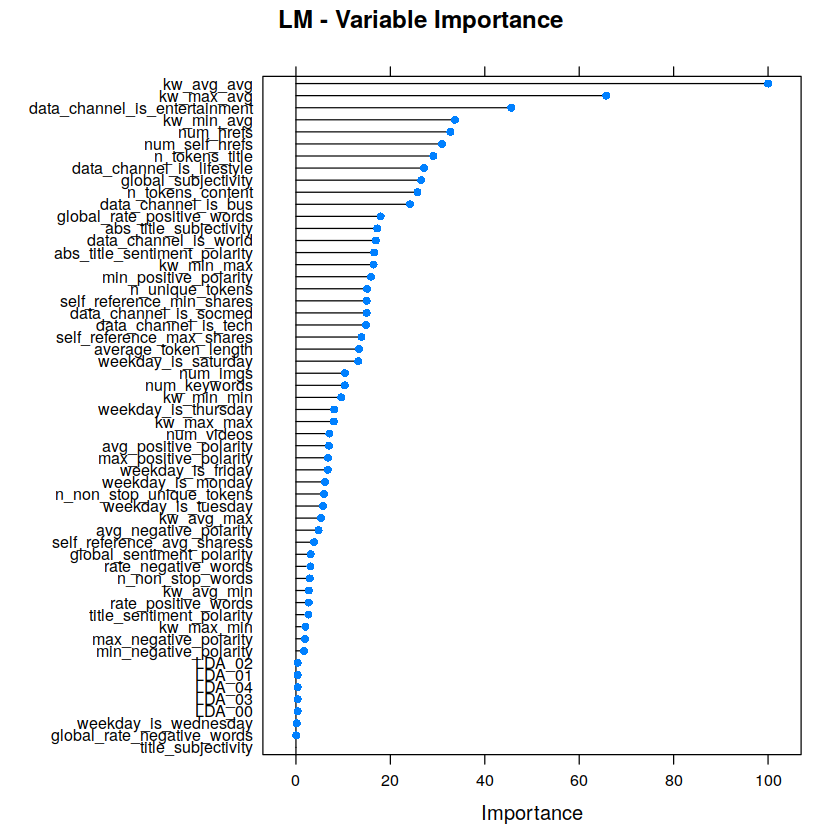

In [11]:
model_lm <- train(shares ~ ., data = train_processed, method = "lm", trControl = fitControl)
plot(varImp(object=model_lm),main="LM - Variable Importance")
summary(model_lm)

## Partial Least Squares

"Partial least squares (PLS) regression is a technique that **reduces the predictors** to a smaller set of **uncorrelated** components and performs **least squares regression** on these components, instead of on the original data. PLS regression is especially useful when your predictors are highly collinear, or when you have more predictors than observations and ordinary least-squares regression either produces coefficients with high standard errors or fails completely."

source: 
http://support.minitab.com/en-us/minitab/17/topic-library/modeling-statistics/regression-and-correlation/partial-least-squares-regression/what-is-partial-least-squares-regression/

"PLS combines features of principal components analysis and multiple regression. It first extracts a set of latent factors that explain as much of the **covariance** as possible between the **independent and dependent variables**. Then a regression step predicts values of the dependent variables using the **decomposition** of the **independent variables**."

source: https://www.ibm.com/support/knowledgecenter/SSLVMB_22.0.0/com.ibm.spss.statistics.help/spss/base/idh_idd_pls_variables.htm

*ABDI, Hervé. Partial least square regression (PLS regression). Encyclopedia for research methods for the social sciences, 2003, 792-795.*

Data: 	X dimension: 31715 56 
	Y dimension: 31715 1
Fit method: oscorespls
Number of components considered: 3
TRAINING: % variance explained
          1 comps  2 comps  3 comps
X           6.608   11.085   16.836
.outcome    1.501    1.768    1.863


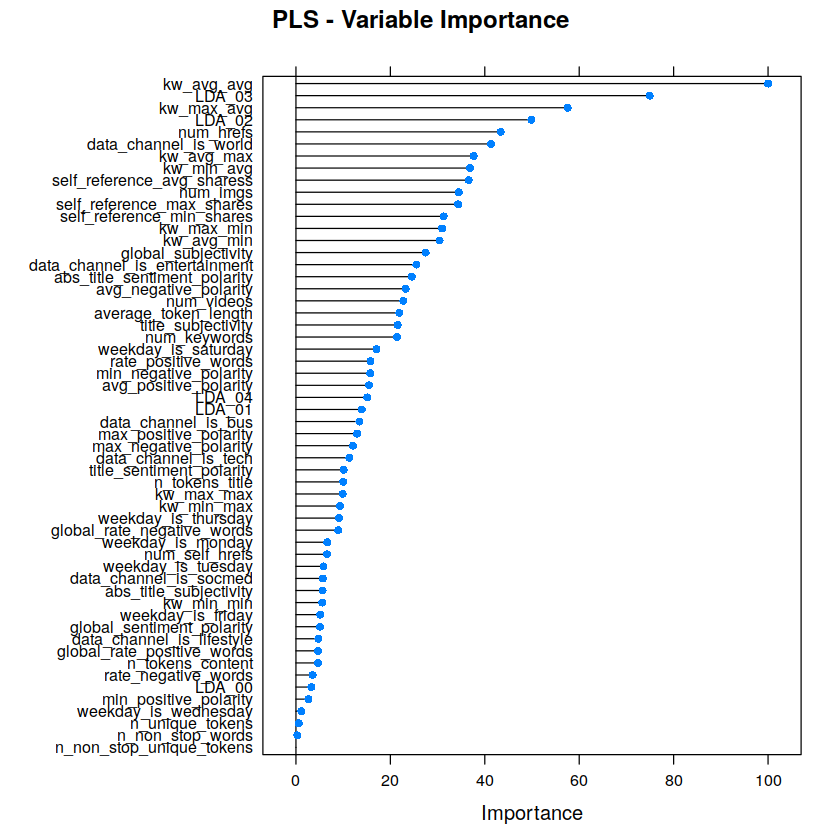

In [12]:
model_pls <- train(shares ~ ., data = train_processed, method = "pls", trControl = fitControl)
plot(varImp(object=model_pls),main="PLS - Variable Importance")
summary(model_pls)

## Principal Component Analysis (PCA)
"Principal components analysis is a procedure for identifying a smaller number of uncorrelated variables, called "principal components", from a large set of data. The goal of principal components analysis is to **explain the maximum amount of variance** with the **fewest** number of **principal components**. Principal components analysis is commonly used in the **social sciences**, market research, and other industries that use large data sets."

source: http://support.minitab.com/en-us/minitab/17/topic-library/modeling-statistics/multivariate/principal-components-and-factor-analysis/what-is-pca/

"Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of **possibly correlated** variables into a set of values of **linearly uncorrelated** variables called **principal components** (or sometimes, principal modes of variation). [...] This transformation is defined in such a way that the **first principal component** has the **largest possible variance** (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components. The resulting vectors are an uncorrelated orthogonal basis set. PCA is **sensitive** to the **relative scaling** of the original variables."

source: https://en.wikipedia.org/wiki/Principal_component_analysis

*BRO, Rasmus; SMILDE, Age K. Principal component analysis. Analytical Methods, 2014, 6.9: 2812-2831.*

### The difference between PCR and PCA
"[...] principal component regression (PCR) is a regression analysis that uses principal component analysis to create explanatory variables before estimating regression coefficients. In PCR instead of regressing the dependent variable on the independent variables directly, the principal components of the independent variables are used."

source: https://stats.stackexchange.com/a/55984
source: https://en.wikipedia.org/wiki/Principal_component_regression

Data: 	X dimension: 31715 56 
	Y dimension: 31715 1
Fit method: svdpc
Number of components considered: 3
TRAINING: % variance explained
          1 comps  2 comps  3 comps
X         8.54297  15.6768    22.12
.outcome  0.08482   0.4467     1.05


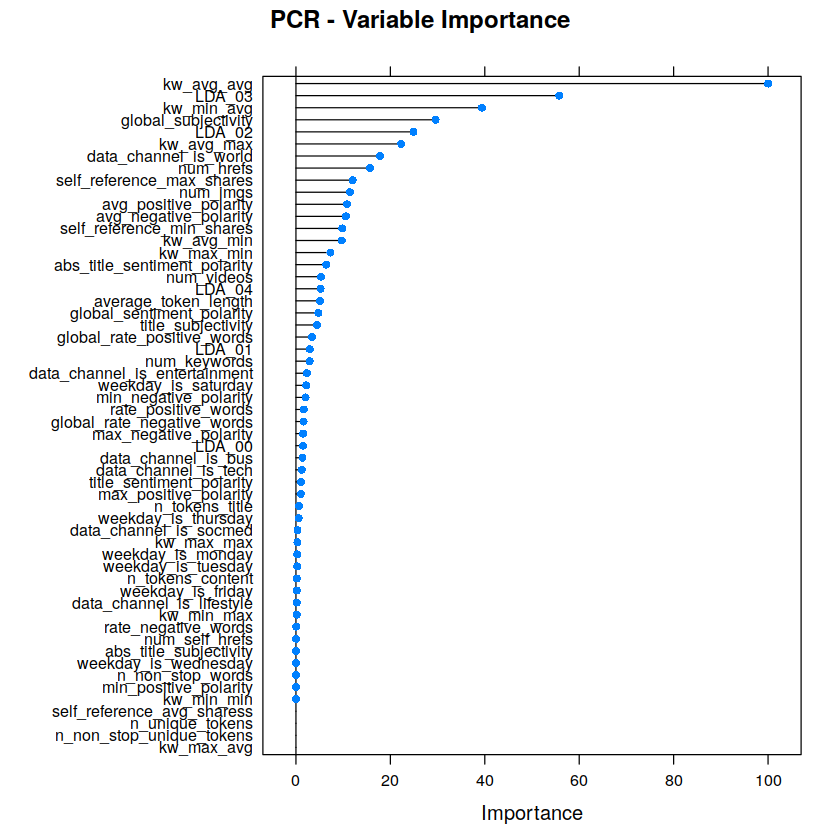

In [13]:
model_pcr <- train(shares ~ ., data = train_processed, method = "pcr", trControl = fitControl)
plot(varImp(object=model_pcr),main="PCR - Variable Importance")
summary(model_pcr)

# 5. Evaluation

## Linear Regression with selected features

In [14]:
## Linear Regression
predictions <- predict.train(object=model_lm_sel, test_processed,type="raw")
postResample(pred = predictions, obs = test_processed$shares)

comparison <- data.frame(head(predictions), head(test_processed$shares))
colnames(comparison) <- c("prediction", "real value")
comparison

## Linear Regression (training set)
predictions_train <- predict.train(object=model_lm_sel, train_processed,type="raw")
postResample(pred = predictions_train, obs = train_processed$shares)

comparison <- data.frame(head(predictions_train), head(test_processed$shares))
colnames(comparison) <- c("prediction", "real value")
comparison

RMSE   Rsquared 
0.92912912 0.02404341

prediction real value 
10 -0.3759586 -0.22732091
13 -0.3253678 -0.21771518
18 -0.3574563 -0.02415548
23 -0.3329757 -0.24984762
32 -0.3812450  0.04384969
33 -0.3865313 -0.24687240

RMSE   Rsquared 
0.99131136 0.01727079

prediction  real value 
11401 -0.06962899 -0.22732091
31251 -0.08182251 -0.21771518
16213  0.11086790 -0.02415548
35004  0.14076687 -0.24984762
37281  0.21386069  0.04384969
1806  -0.15298176 -0.24687240

## Linear Regression

In [15]:
## Linear Regression
predictions <- predict.train(object=model_lm, test_processed,type="raw")
postResample(pred = predictions, obs = test_processed$shares)

comparison <- data.frame(head(predictions), head(test_processed$shares))
colnames(comparison) <- c("prediction", "real value")
comparison

## Linear Regression (training set)
predictions_train <- predict.train(object=model_lm, train_processed,type="raw")
postResample(pred = predictions_train, obs = train_processed$shares)

comparison <- data.frame(head(predictions_train), head(test_processed$shares))
colnames(comparison) <- c("prediction", "real value")
comparison

RMSE   Rsquared 
0.92774197 0.02678648

prediction  real value 
10 -0.35154697 -0.22732091
13 -0.08140852 -0.21771518
18 -0.29504271 -0.02415548
23 -0.27750698 -0.24984762
32 -0.25109148  0.04384969
33 -0.19380770 -0.24687240

RMSE  Rsquared 
0.9891756 0.0215008

prediction  real value 
11401 -0.12501032 -0.22732091
31251 -0.18689619 -0.21771518
16213  0.16955901 -0.02415548
35004  0.10959417 -0.24984762
37281  0.17915365  0.04384969
1806  -0.08612749 -0.24687240

## Partial Least Squares

In [16]:
## Partial Least Squares
predictions <- predict.train(object=model_pls, test_processed,type="raw")
postResample(pred = predictions, obs = test_processed$shares)

comparison <- data.frame(head(predictions), head(test_processed$shares))
colnames(comparison) <- c("prediction", "real value")
comparison

## Partial Least Squares (training set)
predictions_train <- predict.train(object=model_pls, train_processed,type="raw")
postResample(pred = predictions_train, obs = train_processed$shares)

comparison <- data.frame(head(predictions_train), head(test_processed$shares))
colnames(comparison) <- c("prediction", "real value")
comparison

RMSE   Rsquared 
0.92900477 0.02415091

prediction  real value 
1 -0.25851774 -0.22732091
2  0.04041799 -0.21771518
3 -0.16838833 -0.02415548
4 -0.11477003 -0.24984762
5 -0.09821745  0.04384969
6 -0.07743001 -0.24687240

RMSE   Rsquared 
0.99062780 0.01862562

prediction  real value 
1 -0.10375211 -0.22732091
2 -0.13010343 -0.21771518
3  0.27121233 -0.02415548
4  0.10352012 -0.24984762
5  0.20443143  0.04384969
6 -0.06776604 -0.24687240

## Principal Component Analysis

In [17]:
## Principal Component Analysis
predictions <- predict.train(object=model_pcr, test_processed,type="raw")
postResample(pred = predictions, obs = test_processed$shares)

comparison <- data.frame(head(predictions), head(test_processed$shares))
colnames(comparison) <- c("prediction", "real value")
comparison

## Principal Component Analysis (training set)
predictions_train <- predict.train(object=model_pcr, train_processed,type="raw")
postResample(pred = predictions_train, obs = train_processed$shares)

comparison <- data.frame(head(predictions_train), head(test_processed$shares))
colnames(comparison) <- c("prediction", "real value")
comparison

RMSE   Rsquared 
0.93367458 0.01441362

prediction  real value 
1 -0.23953620 -0.22732091
2 -0.09341019 -0.21771518
3 -0.16406211 -0.02415548
4 -0.15103334 -0.24984762
5 -0.18398709  0.04384969
6 -0.17384785 -0.24687240

RMSE   Rsquared 
0.99471951 0.01050189

prediction  real value 
1  0.04483332 -0.22732091
2 -0.08474661 -0.21771518
3  0.01857546 -0.02415548
4  0.04191770 -0.24984762
5  0.17025973  0.04384969
6 -0.19506830 -0.24687240

# 6. Conclusion
Interestingly, in all models the predictions on the train set are outperformed by the prediction on the test set, although only marginally. However, this is subject to change if different random seed is used. Yet again, the difference is marginal and consistent accross models. This is not inconsistent with theory nor overfitting, as overfitting is defined as follows. 

"A hypothesis, h, is said to overfit the training data is there exists another hypothesis which, h´, such that h has **less error** than h´ on the **training** data but **greater error** on independent **test** data."

However, my case is quite the contrary, which might indicate generalization.

Apart from slight changes in order, the most important variables have been chosen consistently accross models. I also investigated a case with Linear Regression using ONLY the selected (most important) variables to see how it differs from a Linear Regression on all variables. The difference was extremely negligible, with slight preference towards the "full" Linear Regression model, indeed.

Due to a limited hardware (and discretionality of the requirement), the formal Feature selection has been omited in favour of the selection of statistically significant variables by each model. However, the code has been included.

For better readability and performance, only the most important variables have been visualised. I have preferred quartiles instead of range to demonstrate the variance of news$shares.